In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.interpolate import interp1d
from scipy.linalg import hankel

import math

In [2]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)
num_cells = len(all_spike_times)

print(f'length of stimulus: {stim.shape}')
print(f'Number of spikes for each of 4 neurons: {" ".join([str(x.size) for x in all_spike_times])}')

# Compute some basic statistics on the stimulus
dt_stim = stim_times[1] - stim_times[0] # time bin size

# Pick a cell to work with
cell_idx = 2
spike_times = all_spike_times[cell_idx]

length of stimulus: (144051,)
Number of spikes for each of 4 neurons: 31528 21553 49954 43126


In [3]:
### == 2. Upsample to get finer timescale representation of stim and spikes === 

# If we want to compare how MAP estimation of the stimulus changes with and without
# spike history to reflect the importance of the specific timing of spikes
# we should use bins that can only contain single spikes
# that way, samples more accurately reflect true inter-spike interval

# Now upsample to finer temporal grid
upsamp_factor = 5 # divide each time bin by this factor
dt_fine = dt_stim/upsamp_factor # use bins 100 time bins finer
tt_fine = np.linspace(dt_fine/2, len(stim)*dt_stim, int((len(stim)*dt_stim)/dt_fine)+1, endpoint=False).T # fine time grid for upsampled stim
# Create binned spike data containing max one spike per bin
spikes_binned = np.histogram(spike_times,tt_fine)[0].T
tt_fine = tt_fine[:-1]
inter_func = interp1d(np.arange(len(stim))*dt_stim, stim, kind='nearest', bounds_error=False, fill_value='extrapolate')
stim_fine = inter_func(tt_fine)

# Separate data into training and testing
# Let's use half the data for calculating the filter, and we will use
# the second half of the data to perform MAP estimation
num_time_bins = len(stim_fine)//2  # of time bins for half of the data
print(f'Using {num_time_bins/(120*5):.2f} seconds of data')
stim_train = stim_fine[:num_time_bins] # reduce stimulus to selected time bins
spikes_binned_train = spikes_binned[:num_time_bins] # reduce spikes

Using 600.21 seconds of data


In [4]:
### ===== 2.98 Create log-likelihood functions ===========
# Let's define some functions that calculates log-likelihood, gradient, and the hessian
# so we can pass them to scipy's automatic solver that will give us
# the optimized parameter fit using ML. This function is taken from tutorial 4.

def neglogli_poissGLM(thetas, xx, yy, dt_bin, vals_to_return=3):
    """ Compute negative log-likelihood of data under Poisson GLM model with
        exponential nonlinearity.
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        xx: ndarray (T X d)
            design matrix
        yy: ndarray (T X 1)
            response variable (spike count per time bin)
        dt_bin: float
            time bin size used
        vals_to_return: int
            which of negative log-likelihood (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
            
        Returns
        -------
        neglogli: float
            negative log likelihood of spike train
        dL: ndarray (d X 1)
            gradient
        H: ndarray (d X d)
            Hessian (second derivative matrix)
    """
    
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas # filter output
    rr = np.exp(vv) * dt_bin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy; # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0
    
    # ---------  Compute Gradient -----------------
    dL1 = -xx.T @ yy # spiking term (the spike-triggered average)
    dL0 = xx.T @ rr # non-spiking term
    dL = dL1 + dL0
    
    # ---------  Compute Hessian -------------------
    H = xx.T @ (xx * np.transpose([rr])) # non-spiking term
    
    if vals_to_return == 3:
        return neglogli, dL, H
    else:
        return [neglogli, dL, H][vals_to_return]

In [5]:
### ==== 2.99 create log posterior functions ======
def neglogposterior(thetas, neglogli_fun, Cinv, vals_to_return=3):
    """ Compute negative log-posterior given a negative log-likelihood function
        and zero-mean Gaussian prior with inverse covariance 'Cinv'.
        
        # Compute negative log-posterior by adding quadratic penalty to log-likelihood
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        neglogli_fun: callable
            function that computes negative log-likelihood, gradient, and hessian.
        Cinv: ndarray (d X d)
            inverse covariance of prior
        vals_to_return: int
            which of negative log-posterior (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
        
        Returns
        -------
        neglogpost: float
            negative log posterior
        grad: ndarray (d X 1)
            gradient
        H: ndarray (d X d)
            Hessian (second derivative matrix)
    """

    neglogpost, grad, H = neglogli_fun(thetas)
    neglogpost = neglogpost + .5 * thetas.T @ Cinv @ thetas       
    grad = grad + Cinv @ thetas
    H = H + Cinv
    
    if vals_to_return == 3:
        return neglogpost, grad, H
    else:
        return [neglogpost, grad, H][vals_to_return]

         Current function value: -89273.325409
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 18
         Hessian evaluations: 18


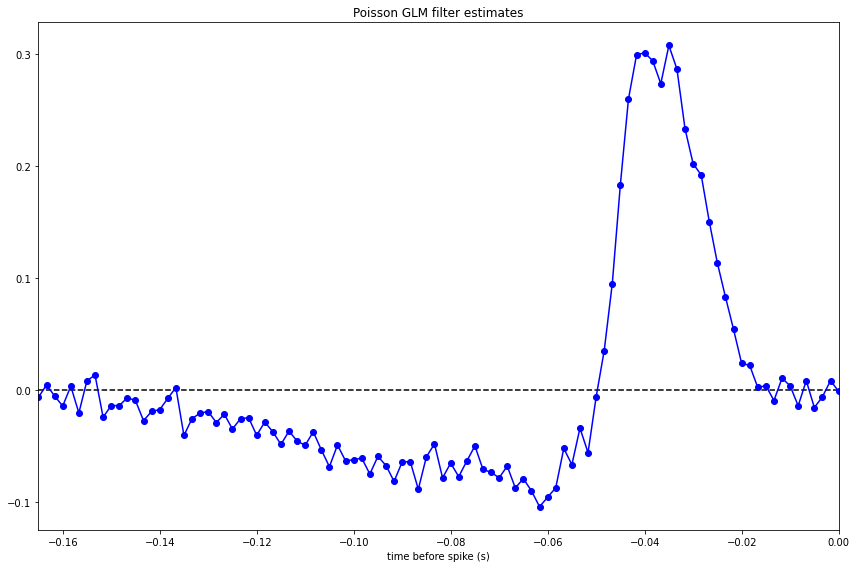

In [8]:
### ==== 3a. Obtain stimulus filter from model without spike history=======

from scipy.sparse import diags
from scipy.linalg import block_diag, hankel, inv, norm
from scipy.optimize import minimize
# Use penalty on the squared differences between filter coefficients,
# penalizing large jumps between successive filter elements. This is
# equivalent to placing an iid zero-mean Gaussian prior on the increments
# between filter coeffs.  (See tutorial 3 for visualization of the prior
# covariance).


# For now, we will just obtain the filter from a model using only the stimulus
ntfilt = 20 * upsamp_factor

# Construct design matrix
padded_stim = np.hstack((np.zeros(ntfilt-1), stim_train[:-ntfilt+1]))   # pad early bins of stimulus with zero
design_mat_stim = np.hstack((np.ones((num_time_bins,1)), hankel(padded_stim, stim_train[-ntfilt:])))

# This matrix computes differences between adjacent coeffs
Dx1 = diags((np.ones((ntfilt,1)) @ [[1,-1]]).T, np.arange(2), (ntfilt-1, ntfilt)).A
Dx = Dx1.T @ Dx1 # computes squared diffs
# Select smoothing penalty
lam = 256
# Embed Dx matrix in matrix with one extra row/column for constant coeff
D = block_diag(0, Dx)

# Define train and test log-likelihood funcs
neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_stim, spikes_binned_train, dt_fine)

# Now compute MAP estimate for each ridge parameter
sta = (design_mat_stim.T @ spikes_binned_train)/np.sum(spikes_binned_train) # compute STA for initialization

# Compute L2-penalized MAP estimate
Cinv = lam*D # set inverse prior covariance
loss_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=0)
grad_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=1)
hess_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=2)
optimizer = minimize(fun=loss_post_func, x0=sta, method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':True})
wmap_stim = optimizer.x[1:]
const_stim = optimizer.x[0]

         Current function value: -95813.695740
         Iterations: 36
         Function evaluations: 26
         Gradient evaluations: 23
         Hessian evaluations: 23


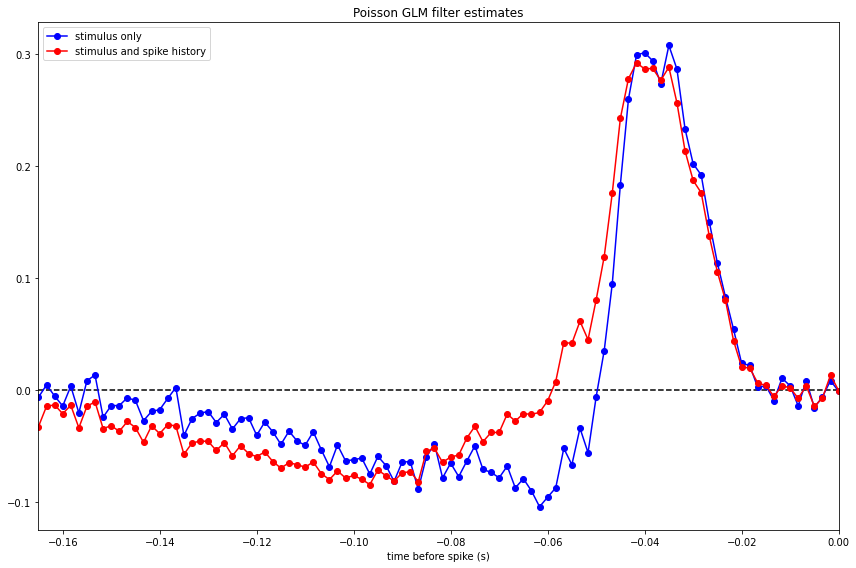

In [12]:
### ==== 3a. Obtain stimulus filter from model with spike history=======

from scipy.sparse import diags
from scipy.linalg import block_diag, hankel, inv, norm
from scipy.optimize import minimize
# Use penalty on the squared differences between filter coefficients,
# penalizing large jumps between successive filter elements. This is
# equivalent to placing an iid zero-mean Gaussian prior on the increments
# between filter coeffs.  (See tutorial 3 for visualization of the prior
# covariance).


# For now, we will just obtain the filter from a model using only the stimulus
nthist = 20 * upsamp_factor

# Build spike-history design matrix
padded_spikes = np.hstack((np.zeros(nthist), spikes_binned_train[:-1]))
design_mat_spikes = hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:])

# Combine these into a single design matrix
design_mat_both = np.concatenate((design_mat_stim, design_mat_spikes), axis=1)

# This matrix computes differences between adjacent coeffs
Dx1 = diags((np.ones((ntfilt+nthist,1)) @ [[1,-1]]).T, np.arange(2), (ntfilt+nthist-1, ntfilt+nthist)).A
Dx = Dx1.T @ Dx1 # computes squared diffs
# Select smoothing penalty
lam = 256
# Embed Dx matrix in matrix with one extra row/column for constant coeff
D = block_diag(0, Dx)

# Define train and test log-likelihood funcs
neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_both, spikes_binned_train, dt_fine)

# Now compute MAP estimate for each ridge parameter
sta = (design_mat_both.T @ spikes_binned_train)/np.sum(spikes_binned_train) # compute STA for initialization

# Compute L2-penalized MAP estimate
Cinv = lam*D # set inverse prior covariance
loss_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=0)
grad_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=1)
hess_post_func = lambda prs : neglogposterior(prs, neglogli_train_func, Cinv, vals_to_return=2)
optimizer = minimize(fun=loss_post_func, x0=sta, method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':True})
wmap_both = optimizer.x[1:ntfilt+1]
sp_hist_filt = optimizer.x[ntfilt+1:]
const_both = optimizer.x[0]

# Let's plot the filter
ttk = np.arange(-ntfilt+1,1)*dt_fine
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)
ax1.plot(ttk,ttk*0, 'k--')
ax1.plot(ttk, wmap_stim/norm(wmap_stim), 'o-', c='b', label='stimulus only')
ax1.plot(ttk, wmap_both/norm(wmap_both), 'o-', c='r', label='stimulus and spike history')
ax1.set_title('Poisson GLM filter estimates')
ax1.set_xlabel('time before spike (s)')
ax1.set_xlim([ttk[0], ttk[-1]])
plt.legend()
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

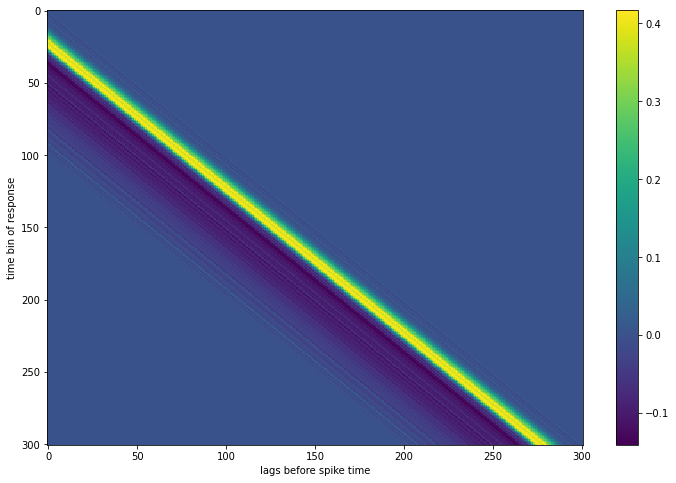

Design matrix shape: 
	(1000, 1000)


In [13]:
### ==== 4. Construct design matrix for MAP estimation ====

from scipy.linalg import toeplitz


# We will now solve for the stimulus that maximizes the posterior
# under a given model (filter). To do this we solve the same equation as before
# xk=y (where x is the stimulus, k is the filter, and y is the neural spikes)
# except now we are solving for x given the k plotted above. We also want to include
# a constant additive value that will contain the prediction for the early
# frames of the neuron, where the previous stimulus was included in training.

# So we need to make a design matrix out of our filter this time...
# Let's also assemble our held-out testing stimulus and binned spikes
# This matrix will be very large, so lets work with chunks of it at a time
num_test_bins = 1000

stim_test = stim_fine[num_time_bins:num_time_bins+num_test_bins] # only use some of the held out data

# The toeplitz operation constructs a matrix with constant digonals
# from the first column and first row
first_column = np.zeros(len(stim_test))
first_column[:ntfilt] = np.flip(wmap_stim)
first_row = np.zeros(len(stim_test))
first_row[0] = wmap_stim[-1]
MAP_design_stim = toeplitz(first_column, first_row)

first_column = np.zeros(len(stim_test))
first_column[:ntfilt] = np.flip(wmap_both)
first_row = np.zeros(len(stim_test))
first_row[0] = wmap_both[-1]
MAP_design_both = toeplitz(first_column, first_row)

# Notice how the filter is a sliding window down the diagonal
# in each row, we are positioning the filter behind the spike we want to predict
plt.clf()
plt.figure(figsize=[12,8])
plt.imshow(MAP_design_stim[:301,:301], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.show()

print('Design matrix shape: ')
print('\t' + str(MAP_design_stim.shape))

In [18]:
### ===== 4b. Remove known quantities about spikes =====

# For the spikes within the first ntfilt-1 of the beginning of the data
# We already know some of the stimulus that predicts them.
# We can account for this by creating a vector containing the known
# stimulus projected onto the parts of the filter missing from the early
# rows of the design matrix, then subtracting that out of the early spikes

# This represents that we are not actually solving xk=y for x, we are solving
# xk+c=y, where c is what we already know about each spike bin
# for the model with spike-history, this c vector also should contain
# the spike-history predictions at each frame

spikes_binned_test = spikes_binned[num_time_bins:num_time_bins+num_test_bins]

known_stim = stim_fine[num_time_bins-(ntfilt-1):num_time_bins]

known_pred = np.zeros(ntfilt-1)
for bin_idx in np.arange(1, ntfilt-1):
    known_pred[bin_idx] = wmap_stim[:-bin_idx] @ known_stim[bin_idx-1:]

    
# Now we can subtract out this known quantity from the spikes
spikes_binned_test_stim = spikes_binned_test.astype(np.float64)
spikes_binned_test_stim[:ntfilt-1] -= known_pred

# We can also subtract the "mean" spikes which is the constant
# from the GLM (coefficient for column of ones)
# spikes_binned_test -= const

known_pred = np.zeros(ntfilt-1)
for bin_idx in np.arange(1, ntfilt-1):
    known_pred[bin_idx] = wmap_both[:-bin_idx] @ known_stim[bin_idx-1:]

# For this model, we also need to subtract out the spike history
# predictions from the spikes.
sp_hist_pred = np.zeros(num_test_bins)
for frame_idx in np.arange(num_test_bins):
    sp_hist_pred[frame_idx] = sp_hist_filt @ spikes_binned[num_time_bins+frame_idx-nthist:num_time_bins+frame_idx]

sp_hist_pred[:ntfilt-1] += known_pred

# Now we can subtract out this known quantity from the spikes
spikes_binned_test_both = spikes_binned_test.astype(np.float64)
spikes_binned_test_both -= sp_hist_pred

Optimization terminated successfully.
         Current function value: -327.421441
         Iterations: 34
         Function evaluations: 35
         Gradient evaluations: 31
         Hessian evaluations: 30
Optimization terminated successfully.
         Current function value: -6151.662026
         Iterations: 68
         Function evaluations: 69
         Gradient evaluations: 60
         Hessian evaluations: 59
(0.27091298802407626, 2.7849065828688035e-18)
(0.1399708687939369, 8.887055187443274e-06)


<Figure size 432x288 with 0 Axes>

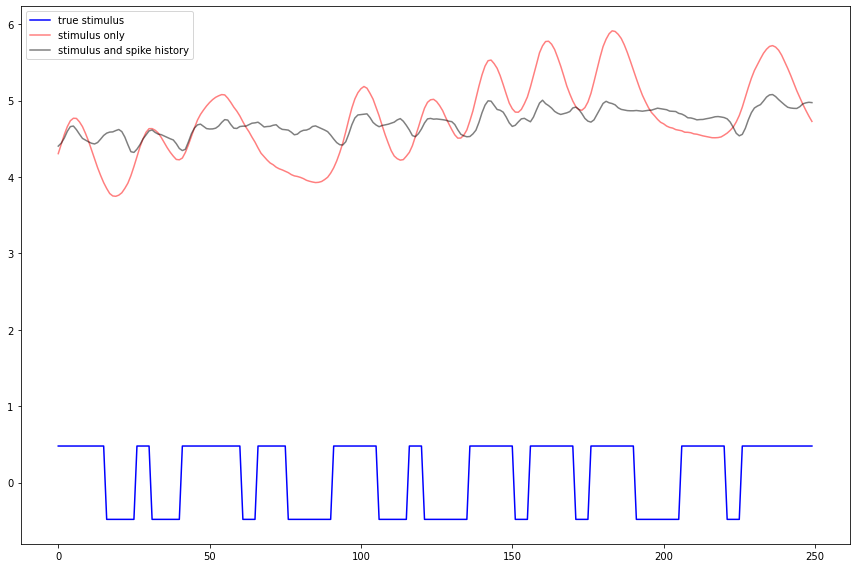

In [21]:
### 5. Fit GLM to get stimulus estimate using same functions as before
# Now we will use the same functions as before to estimate the stimulus
# This is the MAP part. This time we will "regularize" using a gaussian
# with variance equal to the stimulus. This represents the prior
# over the stimulus.
from scipy.stats import pearsonr as pr

# This matrix computes differences between adjacent coeffs
Dx1 = diags((np.ones((num_test_bins,1)) @ [[1,-1]]).T, np.arange(2), (num_test_bins-1, num_test_bins)).A
Dx = Dx1.T @ Dx1 # computes squared diffs
# Select smoothing penalty
lam = 1/np.var(stim_train)
# Embed Dx matrix in matrix with one extra row/column for constant coeff
# D = block_diag(0, Dx)

# Define train and test log-likelihood funcs
neglogli_test_func = lambda prs : neglogli_poissGLM(prs, MAP_design_stim, spikes_binned_test_stim, dt_fine)

# Compute L2-penalized MAP estimate
Cinv = lam*Dx # set inverse prior covariance
loss_post_func = lambda prs : neglogposterior(prs, neglogli_test_func, Cinv, vals_to_return=0)
grad_post_func = lambda prs : neglogposterior(prs, neglogli_test_func, Cinv, vals_to_return=1)
hess_post_func = lambda prs : neglogposterior(prs, neglogli_test_func, Cinv, vals_to_return=2)
optimizer = minimize(fun=loss_post_func, x0=np.zeros(num_test_bins), method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':True})
map_stim = optimizer.x

# Define train and test log-likelihood funcs
neglogli_test_func = lambda prs : neglogli_poissGLM(prs, MAP_design_both, spikes_binned_test_both, dt_fine)

# Compute L2-penalized MAP estimate
Cinv = lam*Dx # set inverse prior covariance
loss_post_func = lambda prs : neglogposterior(prs, neglogli_test_func, Cinv, vals_to_return=0)
grad_post_func = lambda prs : neglogposterior(prs, neglogli_test_func, Cinv, vals_to_return=1)
hess_post_func = lambda prs : neglogposterior(prs, neglogli_test_func, Cinv, vals_to_return=2)
optimizer = minimize(fun=loss_post_func, x0=np.zeros(num_test_bins), method='trust-ncg', jac=grad_post_func, hess=hess_post_func, tol=1e-6, options={'disp':True})
map_both = optimizer.x


# Let's plot the filter
plt.clf()
plt.figure(figsize=[12,8])
plt.plot(stim_test[500:750], c='b', label='true stimulus')
plt.plot(map_stim[500:750], c='r', alpha=.5, label='stimulus only')
plt.plot(map_both[500:750], c='k', alpha=.5, label='stimulus and spike history')
plt.legend()
plt.tight_layout()
print(pr(stim_test, map_stim))
print(pr(stim_test, map_both))